In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

from hysteresis.base import TorchHysteresis
from hysteresis.hybrid import HybridGP
from torchAccelerator.first_order import TorchDrift
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad


def density_function(mesh_pts):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / 0.5)

def objective(R):
    #return (torch.sqrt(R[0,0]) - 2.0e-3)**2 + (torch.sqrt(R[2,2]) - 2.0e-3)**2
    return torch.log(torch.sqrt(
        (torch.sqrt(R[0,0]) - 2e-3)**2 +
        (torch.sqrt(R[2,2]) - 2e-3)**2)
    )


def get_best(input):
    result = torch.empty((len(input), len(input[0])-1))
    for ii in range(len(input)):
        for jj in range(1, len(input[0])):
            result[ii][jj-1] = torch.min(input[ii][:jj])
    return result

def get_model(train_X, train_Y, use_hybrid = False, h_models = None):
    if use_hybrid:
        gpmodel = HybridGP(train_X.clone().detach(),
                           train_Y.clone().detach(), h_models)
    else:
        std_trans = Standardize(1)
        gpmodel = SingleTaskGP(
            train_X.clone().detach(),
            train_Y.clone().detach(),
            outcome_transform=std_trans
        )
        mll = ExactMarginalLogLikelihood(gpmodel.likelihood, gpmodel)
        fit_gpytorch_model(mll)
    return gpmodel

In [2]:
from gpytorch.utils.errors import NotPSDError
from botorch import fit_gpytorch_model
from gpytorch import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from tqdm.notebook import trange


def optimize(
        accelerator_model,
        initial_beam_matrix,
        h_models,
        steps=50,
        use_hybrid = True
):
    iterations = steps

    # initialize with a couple of points
    train_X = torch.ones((3, 3)) * 0.25
    train_X[0] = train_X[0] * 0.0
    train_X[2] = torch.tensor((0.3,-0.6, 0.3))
    train_Y = torch.empty((3, 1))

    for j in range(3):
        accelerator_model.apply_fields({'q1': train_X[j, 0],
                                        'q2': train_X[j, 1],
                                        'q3': train_X[j, 2],})

        train_Y[j] = objective(
            accelerator_model.forward(initial_beam_matrix)
        )

    print(train_X)
    print(train_Y)

    gpmodel = get_model(train_X, train_Y, use_hybrid, h_models)

    for i in range(iterations):
        UCB = UpperConfidenceBound(gpmodel, beta=2.0, maximize=False)

        bounds = torch.stack([-1.0 * torch.ones(3), torch.ones(3)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_X = torch.cat((train_X, candidate))

        # apply candidate
        accelerator_model.apply_fields({'q1': candidate[0,0],
                                        'q2': candidate[0,1],
                                        'q3': candidate[0,2]})

        # make next measurement
        bs = objective(
            accelerator_model.forward(initial_beam_matrix)
        ).reshape(1, 1)
        train_Y = torch.cat((train_Y.clone(), bs.clone()))

        #print(torch.cat((candidate, bs), dim=1))


        # train new model
        try:
            gpmodel = get_model(train_X, train_Y, use_hybrid, h_models)
        except NotPSDError:
            pass

    return train_X, train_Y, accelerator_model, gpmodel

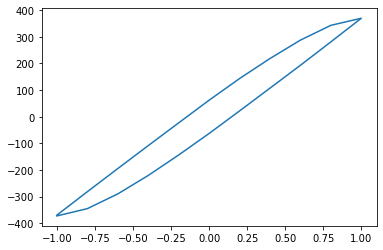

In [3]:
# hysteresis model
H = TorchHysteresis(mesh_scale=0.1, trainable=False)
dens = density_function(H.mesh_points)
H.h_min = -1.0
H.hysterion_density = dens
H.scale = torch.tensor(500.0)

test_H = deepcopy(H)
test_applied_fields = torch.cat(
    (torch.linspace(-1,1,11) , torch.flipud(torch.linspace(-1,1,11)))
)
test_H.applied_fields = test_applied_fields
with torch.no_grad():
    M = test_H.predict_magnetization_from_applied_fields()

fig,ax = plt.subplots()
ax.plot(test_applied_fields, M)

In [4]:
# accelerator model
hmodels = [deepcopy(H), deepcopy(H), deepcopy(H)]

# define quadrupoles
q1 = HysteresisQuad("q1", torch.tensor(0.01), hmodels[0])
d1 = TorchDrift("d1", torch.tensor(1.0))
d2 = TorchDrift("d2", torch.tensor(1.0))
q2 = HysteresisQuad("q2", torch.tensor(0.01), hmodels[1])
d3 = TorchDrift("d3", torch.tensor(1.0))
q3 = HysteresisQuad("q3", torch.tensor(0.01), hmodels[2])

HA = HysteresisAccelerator([q1, d1, q2, d2, q3, d3])

init_beam_matrix = torch.eye(6) * 1.0e-8

# set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0, 0] = 5.0e-3 ** 2
init_beam_matrix[1, 1] = 1.0e-4 ** 2
init_beam_matrix[2, 2] = 5.0e-3 ** 2
init_beam_matrix[3, 3] = 1.0e-4 ** 2
R = init_beam_matrix

In [5]:
# run optimization trials
X = []
Y = []
for ele in [False, True]:
    trace_x = []
    trace_y = []
    for k in trange(25):
        p, l, accelerator_model, gp_hybrid = optimize(
            deepcopy(HA),
            R,
            [deepcopy(H), deepcopy(H), deepcopy(H)],
            steps=50,
            use_hybrid=ele
        )
        trace_x += [p.clone()]
        trace_y += [l.squeeze().detach().clone()]

    X += [torch.vstack([ele.unsqueeze(0) for ele in trace_x])]
    Y += [torch.vstack([ele.unsqueeze(0) for ele in trace_y])]

X = torch.cat([ele.unsqueeze(0) for ele in X])
Y = torch.cat([ele.unsqueeze(0) for ele in Y])
# plot the optimizer trace

  0%|          | 0/25 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2500,  0.2500,  0.2500],
        [ 0.3000, -0.6000,  0.3000]])
tensor([[-3.3900],
        [-3.8605],
        [-3.8800]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
torch.save(X, 'normal_vs_hybrid_x.pt')
torch.save(Y, 'normal_vs_hybrid_y.pt')

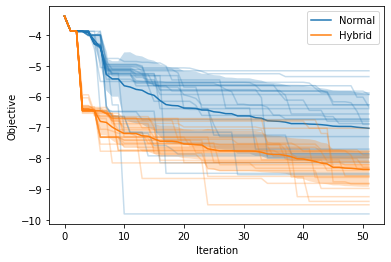

In [7]:
fig2, ax2 = plt.subplots()

c = ['C0','C1']
labels = ['Normal','Hybrid']
for idx, ele in enumerate(Y):
    best = get_best(ele)
    mean = torch.mean(best, dim=0)
    std = torch.std(best, dim=0)
    ax2.plot(mean, c[idx], label=labels[idx])
    ax2.fill_between(range(len(std)), mean-std, mean+std, fc=c[idx], alpha=0.25)

    for k in best:
        ax2.plot(k,c=c[idx],alpha=0.25)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Objective')
ax2.legend()

In [ ]:
fig,ax = plt.subplots()
best = get_best(l.reshape(1,-1))
ax.plot(best.detach().flatten())

In [ ]:
# plot beam size along beamline
#accelerator_model.apply_fields(
#    {"q1": torch.tensor(0.0),"q2": torch.tensor(0.0),"q3": torch.tensor(0.0),}
#)
beam_matrix = accelerator_model.forward(init_beam_matrix, full=False)
print(objective(beam_matrix[-1]))
print(p[-1])

fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)


In [ ]:
# now use the Hybrid GP model to recover the best observed point by using the
# posterior mean acquisition function

acq = UpperConfidenceBound(gp_hybrid, beta = 0.01, maximize=False)

bounds = torch.stack([-1.0 * torch.ones(3), torch.ones(3)])
final_candidate, acq_value = optimize_acqf(
    acq,
    bounds=bounds,
    q=1,
    num_restarts=50,
    raw_samples=1,
    batch_initial_conditions=p.unsqueeze(1)

)


print(final_candidate)
final_candidate = final_candidate.flatten()

# apply final candidate to accelerator
accelerator_model.apply_fields(
    {
        "q1": final_candidate[0],
        "q2": final_candidate[1],
        "q3": final_candidate[2]
    }
)



# plot beam size along beamline
beam_matrix = accelerator_model.forward(init_beam_matrix, full=False)

print(f'final setpoint:{final_candidate}')
print(f'objective value : {objective(beam_matrix[-1])}')
best_candidate_from_optimization = p[torch.argmin(l)]
print(f"best candidate from optimization: {best_candidate_from_optimization}")
print(f'objective value : {torch.min(l)}')

fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)
